In [119]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [5]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [7]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

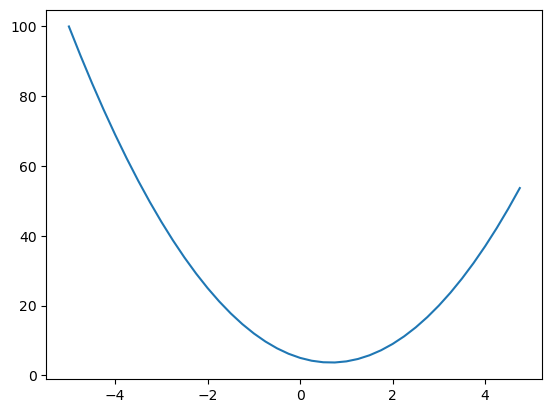

In [8]:
plt.plot(xs, ys)

Derivative: How does function respond (i.e how does y change), when altering input x by some small value h. Does it go up or down, and by how much (what sensitivity)?; this is the slope of that function at that point x

In [14]:
h = 0.0000001
x = -3.0
print(f(x))
print(f(x+h))
slope = (f(x+h) - f(x))/h #Rise over Run, numerical approximation of slope
print(slope)

44.0
43.99999780000003
-21.999999688659955


In [1]:
#More Complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [5]:
h = 0.0001

#inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a +=h
d2 = a*b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [421]:
class Value:
    def __init__(self, data, _children = (), _op="", label = ""):
        self.data = data
        self.grad = 0.0 #Remember derivative/grad of 0, means no effect (i.e subtle change to input/weight has no effect on output/loss); assuming at init that every value does not effect/impact the output
        self._backward = lambda: None #By default is an empty function
        self._prev = set(_children) #Converted to set for efficiancy 
        self._op = _op
        self.label = label

    def __add__(self, other): #Python does not know natively we can add these custom objects, must define __function__
        other = other if isinstance(other, Value) else Value(other) #Allows use to do Value(2) + 1, without having to explicitly define 1 as Value(1)
        out = Value(self.data + other.data, (self, other), "+") #Creating new value object, with Children tracked
        
        def _backward():
            self.grad += 1.0 * out.grad #local derivative of out object w.r.t to input * global derivative (out object w.r.t to final output)
            other.grad += 1.0 * out.grad
    
        out._backward = _backward
        return out
        
    #Note we can call the above using either self.__add__(other) or self + other

    def __neg__(self): #-self
        return self * -1
    
    def __sub__(self, other): #self - other
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out 
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = Value(self.data**other, (self,), f"**{other}")
        
        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad

        out._backward = _backward
        return out
    
    
    def __rmul__(self, other):
    #Needed since mul, faciliates a*2 or a.__mul__(2) but 2*a or 2.__mul__(a) generates an error since Python does not how to multiply number with Value object a
    #Python uses this as a fallback if mul does not work
        return self*other #does _mul_ in appropriate order
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other): #An alternative POV of division
        return self*(other**-1)
    

    def exp(self):
        x = math.exp(self.data)
        out = Value(x , (self, ), "exp")

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad 
        #Concept: Python Closures, the nested _backward() function uses/has access only to ("closes over") the variables from the enclosing scope (i.e outer function) where the inner function (_backward) was created/defined
        #Thus, it 1) captures that self refers to the input value to tanh, 2) captures what the value of t is
        #And so when calling output._backward later, it uses self variable from the enclosing scope which refers to the input, and thus updates the gradient of the input
        out._backward = _backward
        return out

    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v) 

        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()

    def __repr__(self):
        return f"Value(data={self.data})"

In [95]:
a = Value(2.0)
a #Python internally uses the _repr_ function to return the below string; needed for generating output we can interpret

Value(data=2.0)

In [96]:
a = Value(2.0, label = "a")
b = Value(-3.0, label = "b")
c = Value(10.0, label = "c")
e = a*b; e.label = "e"
d = e + c; d.label = "d"
f = Value(-2.0, label = "f")
L = d*f; L.label = "L"

In [97]:
d._prev, d._op, list(d._prev)[-1]._prev

({Value(data=-6.0), Value(data=10.0)},
 '+',
 {Value(data=-3.0), Value(data=2.0)})

In [100]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


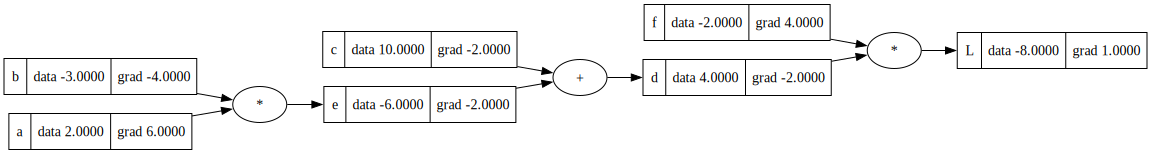

In [116]:
draw_dot(L)

Interested in determining how the weights of a Neural Net, impact the Loss Function; determined via derivatives; allowing for us to iterate on the weights. Not interested in using the derivative of the Loss Function to the data, because we assume the data is fixed.

The gradients above in the figure, denote the derivative of the output, in this case L, with respect to f,d,c,e etc...

Manual Backprop:

Derivative of L w.r.t. L: 1, because if increase L by h, L increases by h, so it is proportional, and derivative is 1

Derivative of L w.r.t to C: We know impact D is having on L, and impact C is having on D, then we should be able to determine how C effects L

Walkthrough: Dd/Dc = 1 (local derivative pertaining to d = c + e), DL/Dd = f, now we use Chain Rule where if var z depends on var y and var y depends on var x, then z is dependent on x, where chain rule is dz/dx = dz/dy * dy/dx (Leibniz's Notation)

Thus, Dl/Dc = Dl/Dd * Dd/Dc = f * 1 = f; thus we can interpret + nodes as routing the gradient to the child nodes, c and e (since Dl/De = f)


Thus, Backprop can be summarized as a recursive multiplication of local derivatives (application of chain rule)

In [115]:
L.grad = 1.0
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

These gradients give us the ability to determine how effecting any of these terms, will alter the final output L. Where for instance an increase in a, where lead to a positive increase in L

In [121]:
def lol():
    """ Function to manually compute numerical aprox. of derivatives """
    h = 0.001

    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a*b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label = "f")
    L = d*f; L.label = "L"
    L1 = L.data

    a = Value(2.0, label = "a")
    b = Value(-3.0, label = "b")
    c = Value(10.0, label = "c")
    e = a*b; e.label = "e"
    d = e + c; d.label = "d"
    f = Value(-2.0, label = "f")
    f.data +=h
    L = d*f; L.label = "L"
    L2 = L.data

    print((L2-L1)/h)

lol()

3.9999999999995595


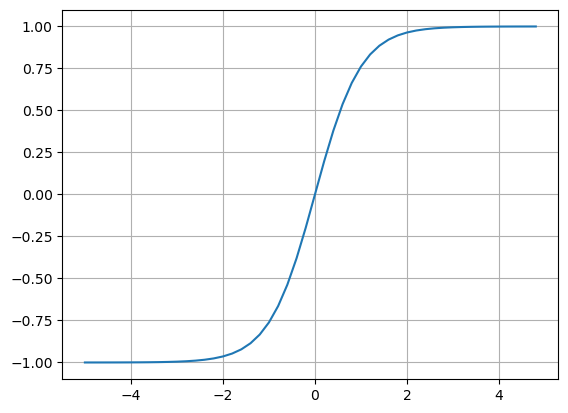

In [120]:
""" TanH Function"""
plt.plot(np.arange(-5, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2))); plt.grid()

#Can see inputs get squashed smoothly, where overly positive inputs get capped at 1 and negative inputs get capped at -1

To use tanh, our current +,* operations wont suffice. There are two options: Breakdown tanh into its most atomic functions and incorporate those into the value object, or we can straight use the tanh function in the value object, ultimately the most important point is that as long as we know how to create the local derivative of how the inputs impact the outputs

Neuron: Activation Function (Dot_Product(Weights, inputs))

In [129]:
#Inputs x1, x2, 2-dim
#Outputs, 1

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias
b = Value(6.88137, label = "b")

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

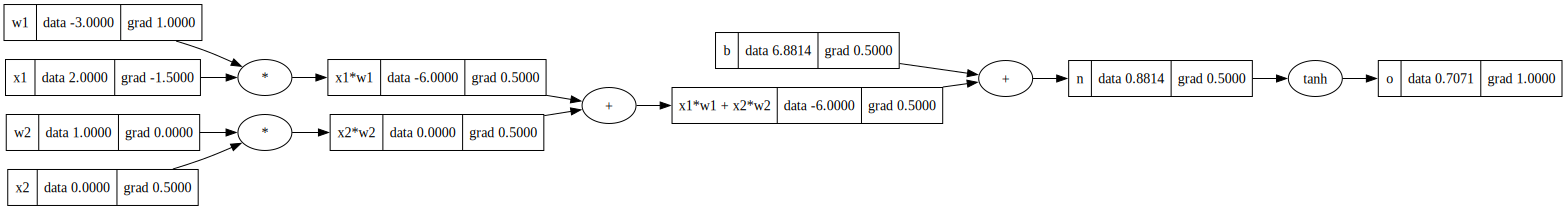

In [142]:
draw_dot(o)

In [162]:
o.grad = 1
n.grad = 1 - (n.tanh().data)**2
b.grad = 0.5
x1w1x2w2.grad = 0.5
x1w1.grad = 0.5
x2w2.grad = 0.5
w1.grad = 1.0
w2.grad = 0 #x2.data * x2w2.grad
x1.grad = -1.5
x2.grad = 0.5

In [170]:
#Inputs x1, x2, 2-dim
#Outputs, 1

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias
b = Value(6.88137, label = "b")

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

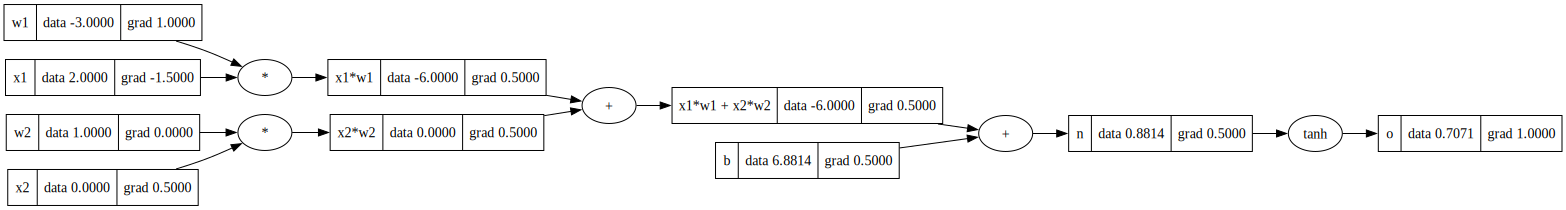

In [177]:
draw_dot(o)

In [176]:
o.grad = 1.0 #Base Case
o._backward() #Will compute the local gradient of o xw.r.t to n (which was its input), and apply chain rule by multiplying it by global gradient of do/do, to get do/dn
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

We need to ensure, that we not call .backward for any one node, before we have gotten all its dependencies (I.e all of its dependencies must propogate to it) 

This ordering of graphs can be achieved through using topological sort: A layout which ensures edges only go left to right

In [179]:
"Implementation of topological graph"

topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v) #Will only add v to list, once all the children of v have been processed
build_topo(o)
#Can see o is the last element added to the list
topo

[Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=-6.0),
 Value(data=6.88137),
 Value(data=0.8813700000000004),
 Value(data=0.7071049876722272)]

In [312]:
#Inputs x1, x2, 2-dim
#Outputs, 1

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias
b = Value(6.88137, label = "b")

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"

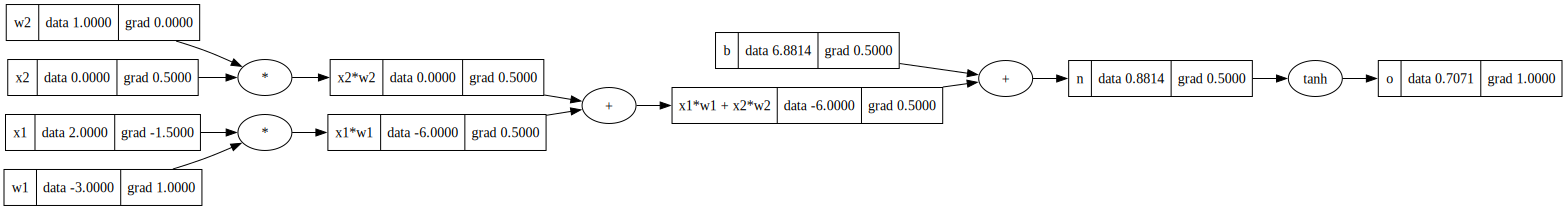

In [315]:
draw_dot(o)

In [314]:
# o.grad = 1.0

# topo = []
# visited = set()
# def build_topo(v):
#     if v not in visited:
#         visited.add(v)
#         print(v.label)
#         print(v._prev)
#         for child in v._prev:
#             build_topo(child)
#         topo.append(v) #Will only add v to list, once all the children of v have been processed
# build_topo(o)
# topo

# for node in reversed(topo):
#     node._backward()

In [ ]:
o.backward() 

What about when we use the same elements twice? Currently there is a bug...

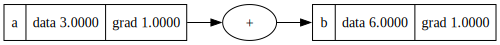

In [316]:
a = Value(3.0, label = "a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)
#Gradient should be equal to 2.0

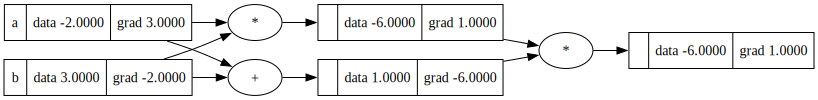

In [319]:
a = Value(-2.0, label = "a")
b = Value(3.0, label = "b")

d = a*b; label = "d"
e = a+b; label = "e"
f = d*e; label = "f"

f.backward()

draw_dot(f)

The solution, according to multivariate chain rule, is to add/accumulate the gradients (ie +=)

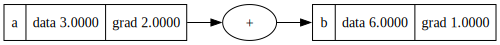

In [322]:
a = Value(3.0, label = "a")
b = a + a; b.label = "b"
b.backward()
draw_dot(b)
#Now it has correct gradient

[]
Value(data=6.0)
[]
Value(data=2.0)
[]
Value(data=4.0)
[]
Value(data=-2.0)
[Value(data=4.0)]
Value(data=3.0)
[Value(data=4.0), Value(data=-2.0), Value(data=2.0)]
Value(data=5.0)
[Value(data=4.0), Value(data=-2.0), Value(data=2.0), Value(data=3.0), Value(data=6.0)]
Value(data=2.0)
[Value(data=4.0), Value(data=-2.0), Value(data=2.0), Value(data=3.0), Value(data=6.0)]
Value(data=3.0)
[Value(data=4.0), Value(data=-2.0), Value(data=2.0), Value(data=3.0), Value(data=6.0)]
[Value(data=4.0), Value(data=-2.0), Value(data=2.0), Value(data=3.0), Value(data=6.0), Value(data=5.0), Value(data=30.0)]


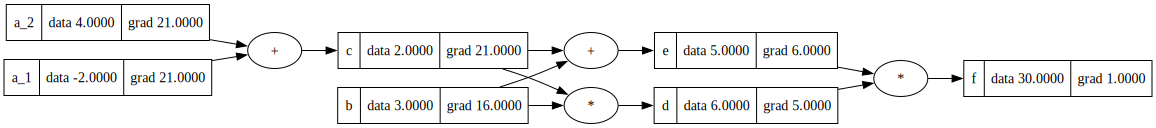

In [337]:
a_1 = Value(-2.0, label = "a_1")
a_2 = Value(4.0, label = "a_2")
c = a_1 + a_2; c.label = "c"
b = Value(3.0, label = "b")

d = c*b; d.label = "d"
e = c+b; e.label = "e"
f = d*e; f.label = "f"

f.backward()

draw_dot(f)

The above, walks through the topological graph to better understand how appropriate order of backprop is determined

Let's breakdown tanh into its componenets, and show the same results can be obtained as one of the earlier gradient computations

In [340]:
#Inputs x1, x2, 2-dim
#Outputs, 1

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias
b = Value(6.88137, label = "b")

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"
o = n.tanh(); o.label = "o"
o.backward()

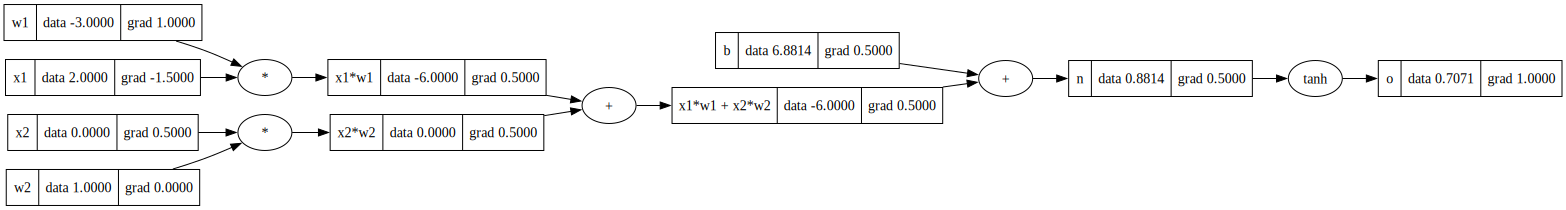

In [341]:
draw_dot(o)

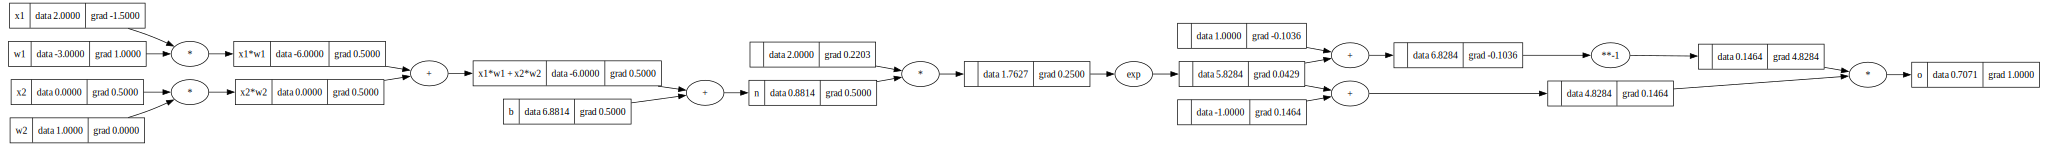

In [363]:
#Broken down TanH

#Inputs x1, x2, 2-dim
#Outputs, 1

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")
#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")
#bias
b = Value(6.88137, label = "b")

#x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label = "x1*w1"
x2w2 = x2*w2; x2w2.label = "x2*w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = "o"
o.backward()
draw_dot(o)

Wanted to further illustrate the level in which you implement processes is up to, can implement for tiny individual processes such as + or -, or can do it for composite operations such as TanH; as long as you can write a local gradient, you chain the gradient with the global gradient and continue backprop 

In [370]:
import torch

x1 = torch.Tensor([2.0]).double()   ; x1.requires_grad = True #Double ensures uses Float64, like python, whereas by default torch use Float32
w2 = torch.Tensor([0.0]).double()   ; w2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()  ; w1.requires_grad = True
x2 = torch.Tensor([1.0]).double()   ; x2.requires_grad = True
b = torch.Tensor([6.88]).double()   ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())

0.7064193777288968
---
x2 0.0
w2 0.5009716627691181
x1 -1.5029149883073543
w1 1.0019433255382362


In [491]:
import random

class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = self.b
        act = sum((weight_i* x_i for weight_i, x_i in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
        
class Layer:

    def __init__(self, nin, nout): #nout denotes num of neurons in layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params
    
class MLP:

    def __init__(self, nin, nouts): #nouts defines a list of all the sizes of layers you want in MLP
        sz = [nin] + nouts 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1]
n = MLP(3, [4,4,1])
n(x)

Value(data=-0.3796375324599889)

In [452]:
n.parameters(), len(n.parameters())

([Value(data=0.7602957505992318),
  Value(data=-0.6917262156187316),
  Value(data=0.09426849079231947),
  Value(data=-0.8680911705963454),
  Value(data=0.9820359609997102),
  Value(data=-0.7247261711328385),
  Value(data=-0.026376043463365084),
  Value(data=-0.30582745249103627),
  Value(data=0.46436063602339583),
  Value(data=-0.6661509794362341),
  Value(data=0.6104913900014113),
  Value(data=0.7971100025677067),
  Value(data=-0.6510474041769478),
  Value(data=-0.5036035805129166),
  Value(data=-0.20962714081734268),
  Value(data=-0.04645049728813566),
  Value(data=-0.09203247095344746),
  Value(data=-0.8355200036616601),
  Value(data=-0.7257668489270868),
  Value(data=-0.2315890197276942),
  Value(data=0.4197911800762868),
  Value(data=0.7687110106846127),
  Value(data=0.3344692140838754),
  Value(data=-0.008065555209908482),
  Value(data=-0.455421244993534),
  Value(data=-0.39717579199953335),
  Value(data=0.911639006249225),
  Value(data=-0.8577918104007007),
  Value(data=-0.83458

In [453]:
# draw_dot(n(x))

In [454]:
xs = [[2.0, 3.0, -1.0], [3.0, -1.0, 0.5], [0.5, 1.0, 1.0], [1.0, 1.0, -1.0]]
ys = [1.0, -1.0, -1.0, 1.0]
y_pred = [n(x) for x in xs]
y_pred

[Value(data=0.4381348276265269),
 Value(data=0.5907508356231695),
 Value(data=0.4520152682356142),
 Value(data=0.45812590556504657)]

We use a single number to measure the total performance of NN, Loss. We compute mean squared loss. Measures accuracy of predictions, will be low when predictions are matching targets. I.E loss is manipulated such that when it is low, the network is doing what you want it do on your problem

In [455]:
[(yout - ygt)**2 for ygt, yout in zip(ys, y_pred)]

[Value(data=0.31569247192627264),
 Value(data=2.5304882210358124),
 Value(data=2.1083483391893427),
 Value(data=0.2936275342197008)]

In [456]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
loss

Value(data=5.248156566371128)

The lowest loss can be is 0, so the greater it is, the worst off the NN is predicting

In [457]:
loss.backward()

In [460]:
n.layers[0].neurons[0].w[0].data, n.layers[0].neurons[0].w[0].grad

(0.7602957505992318, -0.021517202096407007)

Can see because of backward pass, we have a gradient for the weight

#Negative gradient, means weight has negative infleunce on loss, such that as weight increases, loss goes down

In [459]:
# draw_dot(loss)
#Will generate an excessive graph, becase it has 4 forward passes through NN ( 4 examples), then has the loss on top and ends with the value of the loss. This loss will backprop through all 4 of the forward passes

In gradient descent, we are thinking of the gradient as a vector pointing in the direction of increased loss. We are modifying the parameters in a small step size in the OPPOSITE direction of the gradient

In [461]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [463]:
n.layers[0].neurons[0].w[0].data

#Can see a small increase the param, which according to gradient shold make loss go down

0.7605109226201959

In [485]:
y_pred = [n(x) for x in xs]
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
loss
#So loss has decreased, and we just need to iterately do forward pass, backward pass, update

Value(data=1.5123024977907432e-05)

In [483]:
loss.backward()

In [484]:
for p in n.parameters():
    p.data += -0.05 * p.grad

We dont want to do big a step, as we can overstep, and this is because we do not know the structure of the loss function. We only know about the very local dependence of these parameters on the loss, but if we step to far, we might step into a part of the loss, which is very different and that can destabilize trraining and cause loss to blow up

if too low, takes too long to converge

if too large, the whole thing is unstable and cna explode the loss

In [486]:
y_pred

[Value(data=0.9995986452865455),
 Value(data=-0.9999915928692252),
 Value(data=-0.9961322499834143),
 Value(data=0.9999512301194495)]

In [492]:
#gradient descent
for k in range(20):
    #Forward Pass
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

    #Backward Pass
        #Need to zero out the grads computed from prior iterations
    for p in n.parameters():
        p.grad = 0.0
    

    loss.backward()

    #Update Step
    for p in n.parameters():
        p.data += -0.05 * p.grad

    print(k, loss.data)

0 5.979159885139647
1 3.0640056245192193
2 2.0561396668821463
3 1.2689435205435295
4 0.7739883981011684
5 0.5087727411662849
6 0.36344530061347535
7 0.27677030756586907
8 0.22077907350409592
9 0.18223193112288266
10 0.15434582763191382
11 0.13337124310876733
12 0.11709666832385057
13 0.10414540789476703
14 0.09362108346149044
15 0.08491765122748805
16 0.07761207799043553
17 0.07140090278202885
18 0.06606124343356078
19 0.06142600015702847


In [493]:
y_pred

[Value(data=0.900666549407294),
 Value(data=-0.8931294791198723),
 Value(data=-0.8621947664069691),
 Value(data=0.8545789729387278)]

In [ ]:
#Useful article to understand how gradients are computed iver multiple examples

https://stats.stackexchange.com/questions/266968/how-does-minibatch-gradient-descent-update-the-weights-for-each-example-in-a-bat